<a href="https://colab.research.google.com/github/AgniKoko/Fetal_ECG_Separation/blob/agni/Fetal_ECG_Separation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Fetal ECG Seperation**
## A project for the class of **Electronic Measurements** (DUTH ECE: 8th Semester 2024-2025)

## - Κοκοροτσίκου Αγνή Ιωάννα / Kokorotsikou Agni Ioanna (58767)
## - Ξανθόπουλος Ηλίας / Xanthopoulos Ilias (58545)

## **Part 0**: Set-Up

1) Mount Google drive and load dataset.

In [127]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [128]:
# import os
# import zipfile

# data_dir = '/content/drive/MyDrive/Fetal_ECG_Separation'
# database_zip = os.path.join(data_dir, 'database-1.0.0.zip')

# with zipfile.ZipFile(database_zip, 'r') as zip_ref:
#     zip_ref.extractall('/content')

# print("Dataset extracted successfully.")

2) Install and import libraries.

In [129]:
!pip install wfdb
!pip install pyedflib

In [130]:
import wfdb
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
from scipy.fftpack import fft, fftfreq
from sklearn.decomposition import FastICA
import pyedflib
import seaborn as sns

import wfdb
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.signal import butter, filtfilt, spectrogram, stft, find_peaks
from scipy.fft import rfft, rfftfreq, irfft
from sklearn.decomposition import FastICA
import os
import zipfile
import pyedflib

In [131]:
data_dir = '/content/drive/MyDrive/ColabNotebooks/Fetal_ECG_Separation'
database_zip = os.path.join(data_dir, 'database-1.0.0.zip')

# train_dir = '/content/train/'
# os.makedirs(train_dir, exist_ok=True)

with zipfile.ZipFile(database_zip, 'r') as zip_ref:
    zip_ref.extractall('/content')

print("Dataset extracted successfully.")

Dataset extracted successfully.


## **Part 1**: Signal Extraction

1) Read .edf file of choice, extract saved signals and print useful data information. Seperate ground truth signal ('Direct_1') from the abdomen signals and save QRS types and timestamps of ground truth.

In [303]:
# Input EDF file name
# ----------------------
rec = 'r07'
# ----------------------

file_path = f'/content/abdominal-and-direct-fetal-ecg-database-1.0.0/{rec}.edf'
edf_file = pyedflib.EdfReader(file_path)

signal_num = edf_file.signals_in_file
signal_labels = edf_file.getSignalLabels()
fs = edf_file.getSampleFrequency(0)  # Fs: Sampling Frequency

signals_list = [edf_file.readSignal(i) for i in range(signal_num)]
signals = np.array(signals_list)

print(f"There are {signal_num} signals/channels in edf file.")
print("Signal Labels:", signal_labels)
print(f"Sampling frequency fs: {fs}Hz")
print("(Num of channels, Num of samples over time) = ", signals.shape)

edf_file._close()

ground_truth = signals[0,:]
abdomen_signals = signals[1:,:]

qrs_annotations = wfdb.rdann(file_path, "qrs")

qrs_peaks = np.array(qrs_annotations.sample)
qrs_symbols = np.array(qrs_annotations.symbol)

rr_intervals = np.diff(qrs_peaks)
print("RR Intervals (samples):", rr_intervals[:10])

There are 5 signals/channels in edf file.
Signal Labels: ['Direct_1', 'Abdomen_1', 'Abdomen_2', 'Abdomen_3', 'Abdomen_4']
Sampling frequency fs: 1000.0Hz
(Num of channels, Num of samples over time) =  (5, 300000)
RR Intervals (samples): [476 477 478 476 475 473 471 471 470 468]


In [304]:
rr_intervals_sec = rr_intervals / fs
print("RR Intervals (seconds):", rr_intervals_sec[:10])
min_rr = np.min(rr_intervals_sec)
print("Minimum RR Interval (seconds):", min_rr)

RR Intervals (seconds): [0.476 0.477 0.478 0.476 0.475 0.473 0.471 0.471 0.47  0.468]
Minimum RR Interval (seconds): 0.462


In [305]:
instantaneous_hr_hz = 1 / rr_intervals_sec
instantaneous_hr_bpm = instantaneous_hr_hz * 60
print("Instantaneous Heart Rates (Hz):", instantaneous_hr_hz[:10])
print("Instantaneous Heart Rates (bpm):", instantaneous_hr_bpm[:10])
print(np.max(instantaneous_hr_hz))

Instantaneous Heart Rates (Hz): [2.10084034 2.09643606 2.09205021 2.10084034 2.10526316 2.1141649
 2.12314225 2.12314225 2.12765957 2.13675214]
Instantaneous Heart Rates (bpm): [126.05042017 125.78616352 125.52301255 126.05042017 126.31578947
 126.84989429 127.38853503 127.38853503 127.65957447 128.20512821]
2.1645021645021645


2) Plot extracted signals over a specified amount of time. For the ground truth, plot the peaks of QRS complex according to saved timestamps as well.

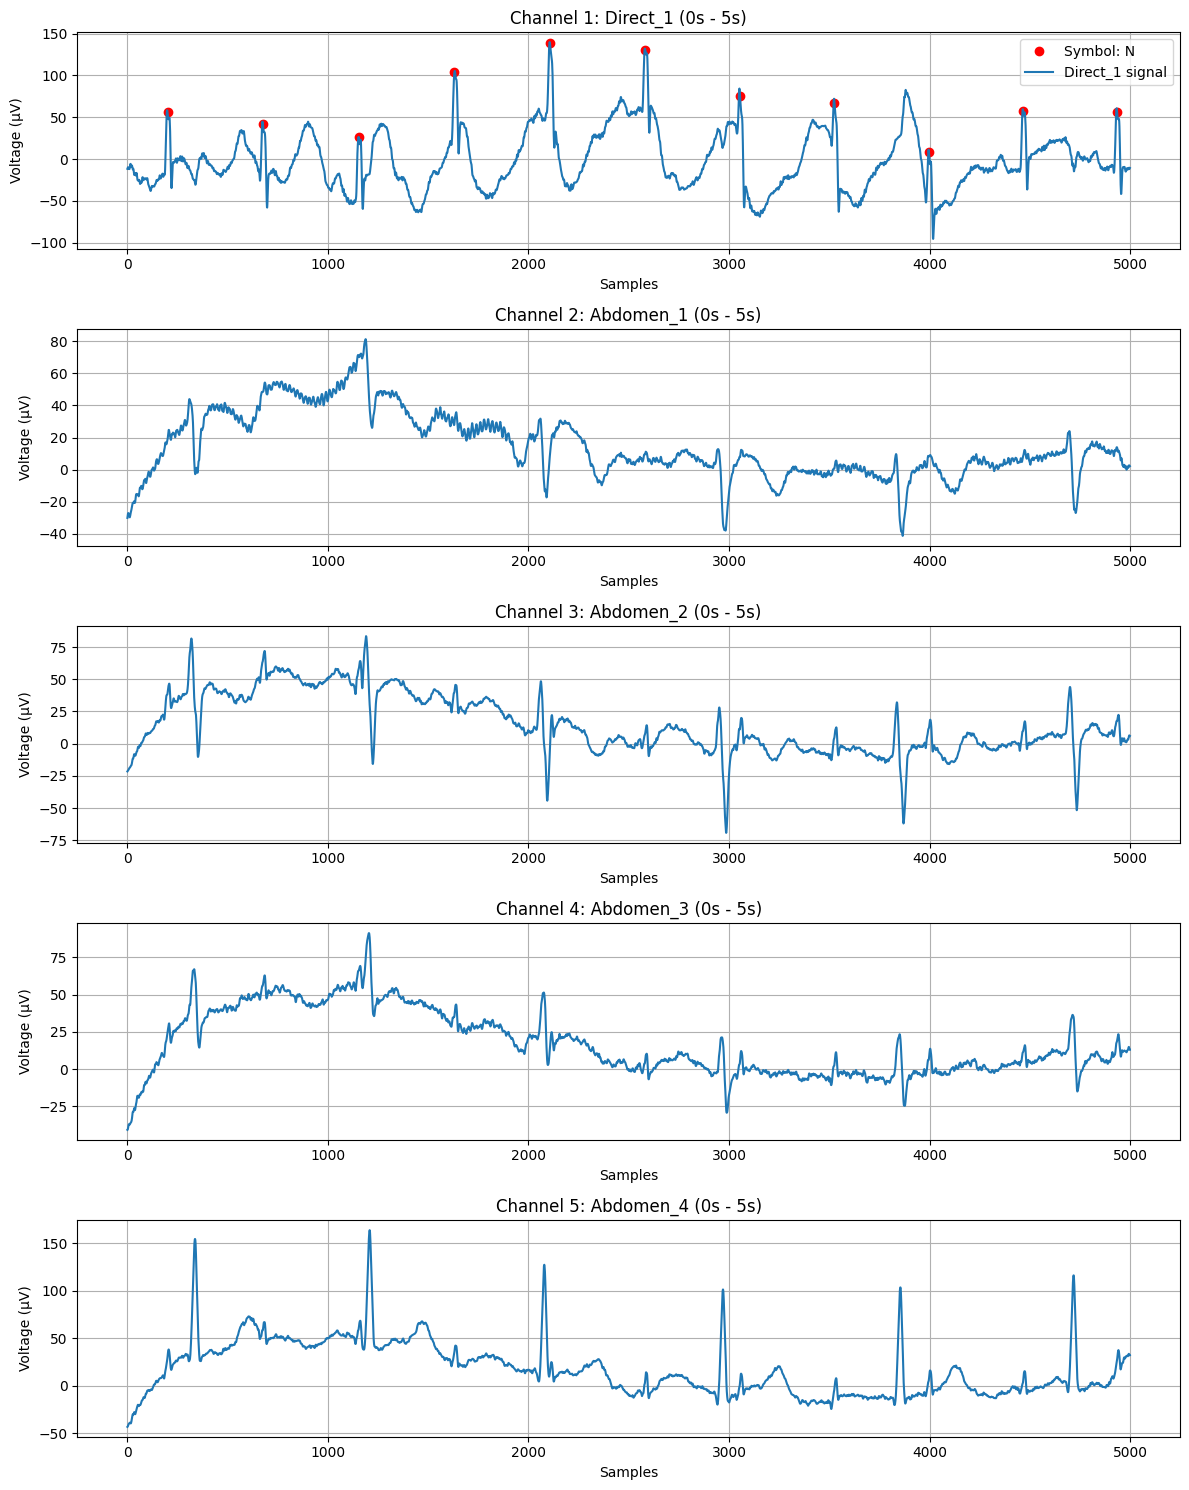

In [306]:
# Input start time and duration (in seconds) for signal plots.
# ----------------------
start_time = 0
duration = 5  # Each signal lasts 300sec.
# ----------------------

# ex. For duration = 3000 sec, 300 * fs = 300 * 1000 = 300000 samples.
start_samp = start_time * int(fs)
fin_samp = (start_time + duration) * int(fs)

symbol_colors = {
    'N': 'r',  # Normal beat - red
    'V': 'g',  # Ventricular - green
    'A': 'yellow',  # Atrial - yellow
    'L': 'orange',  # LBBB - orange
    'R': 'purple',  # RBBB - purple

    '': 'k'   # Unspecified - black
}

cropped_signals = signals[:, start_samp:fin_samp]
cropped_qrs = qrs_peaks[(qrs_peaks >= start_samp) & (qrs_peaks < fin_samp)]
cropped_sym = qrs_symbols[(qrs_peaks >= start_samp) & (qrs_peaks < fin_samp)]
channel_num = cropped_signals.shape[0]

plt.figure(figsize=(12, 3 * channel_num))

for symbol in np.unique(cropped_sym):
    color = symbol_colors.get(symbol, 'gray')  # default to gray if unknown
    sym_samples = cropped_qrs[cropped_sym == symbol] - start_samp
    plt.subplot(channel_num, 1, 1)
    plt.plot(sym_samples, cropped_signals[0,sym_samples], 'o', color=color, label=f'Symbol: {symbol}')

plt.plot(cropped_signals[0,:], label='Direct_1 signal')
plt.title(f'Channel {1}: {signal_labels[0]} ({start_time}s - {start_time + duration}s)')
plt.xlabel('Samples')
plt.ylabel('Voltage (μV)')
plt.legend()
plt.grid()

for i in range(1, channel_num):
    plt.subplot(channel_num, 1, i + 1)
    plt.plot(cropped_signals[i,:])
    plt.title(f'Channel {i+1}: {signal_labels[i]} ({start_time}s - {start_time + duration}s)')
    plt.xlabel('Samples')
    plt.ylabel('Voltage (μV)')
    plt.grid()

plt.tight_layout()
plt.show()

3) Calculate instantaneous Heart Rate over time. Interpolate to achieve a continuous graph and plot the results over a specified amount of time.

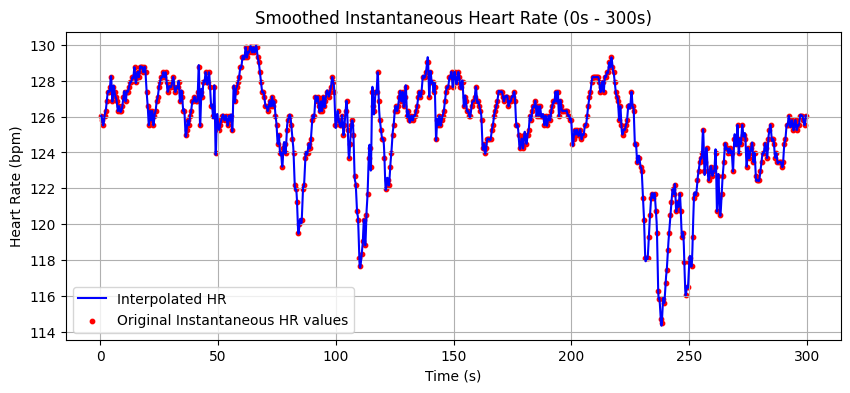

In [307]:
from scipy.interpolate import interp1d

# Input start time and duration (in seconds) for Heart Rate plot.
# Input the points/sec for interpolated Hear Rate.
# ----------------------
start_time = 0
duration = 300 # Signal lasts 300sec.

resolution = 50 # (50-100) recommended
# ----------------------

end_time = start_time + duration

rr_intervals_sec = np.diff(qrs_peaks) / fs
instantaneous_hr_hz = 1 / rr_intervals_sec
instantaneous_hr_bpm = instantaneous_hr_hz * 60

qrs_timestamps = qrs_peaks / fs
hr_timestamps = (qrs_timestamps[:-1] + qrs_timestamps[1:]) / 2

time_mask = (hr_timestamps >= start_time) & (hr_timestamps < end_time)
cropped_hr_times= hr_timestamps[time_mask]
cropped_hr_bpm = instantaneous_hr_bpm[time_mask]

time_span = cropped_hr_times[-1] - cropped_hr_times[0]
time_space = np.linspace(cropped_hr_times[0], cropped_hr_times[-1], num=int(time_span * resolution))

hr_func = interp1d(cropped_hr_times, cropped_hr_bpm, kind='cubic')
continuous_hr = hr_func(time_space)

plt.figure(figsize=(10, 4))
plt.plot(time_space, continuous_hr, color='b', label='Interpolated HR')
plt.scatter(cropped_hr_times, cropped_hr_bpm , color='r', s=10, label='Original Instantaneous HR values')
plt.title(f'Smoothed Instantaneous Heart Rate ({start_time}s - {end_time}s)')
plt.xlabel('Time (s)')
plt.ylabel('Heart Rate (bpm)')
plt.grid(True)
plt.legend()
plt.show()

## **Part 2**: Independent Component Analysis (ICA) Application

1) Check if data needs whitening. Print mean value of signals and covariance matrix. Plot a heatmap of covariance matrix for better visualization.

Data needs whitening if the mean value of each signal is non-zero (meaning that the signals need centering) and/or the covariance matrix is not equal to the identity matrix.

The mean value of each abdomen channel is: [[0.26987645 0.28847407 0.30070059 0.31290644]]
Signals need centering: True

Covariance Matrix:
[[1128.2313204  1209.16048976 1213.16621273 1205.6142864 ]
 [1209.16048976 1521.1807373  1380.80746824 1444.28159289]
 [1213.16621273 1380.80746824 1445.20096714 1596.64238564]
 [1205.6142864  1444.28159289 1596.64238564 2005.26600356]]

Deviation from Identity (Frobenius norm): 5616.296276717206
Data needs whitening: True



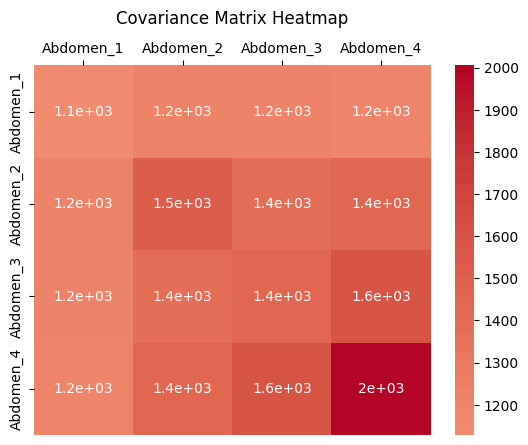

In [308]:
abd_signal_mean = np.mean(abdomen_signals, axis=1, keepdims=True)
center_flag = not np.allclose(abd_signal_mean, np.zeros((abdomen_signals.shape[0],1)),
                                 atol=1e-5)

# Mean array is transposed for clearer reading.
print(f"The mean value of each abdomen channel is:", abd_signal_mean.T)
print("Signals need centering:", center_flag)
print()

cov_mat = np.cov(abdomen_signals)
identity = np.eye(cov_mat.shape[0])
deviation_flag = not np.allclose(cov_mat, identity, atol=1e-5)
error = np.linalg.norm(cov_mat - identity)

print("Covariance Matrix:")
print(cov_mat)
print()

print("Deviation from Identity (Frobenius norm):", error)
print("Data needs whitening:", deviation_flag)
print()

cov_heat = sns.heatmap(cov_mat, annot=True, cmap='coolwarm',center=0,
            xticklabels=signal_labels[1:], yticklabels=signal_labels[1:])

cov_heat.xaxis.set_ticks_position('top')
cov_heat.xaxis.set_label_position('top')
cov_heat.tick_params(top=True, bottom=False, labeltop=True, labelbottom=False)
plt.title("Covariance Matrix Heatmap", pad=30)
plt.show()

2) Perform ICA over the abdomen signals. Whitening is applied before ICA, if necessary.

In [309]:
if (deviation_flag or center_flag):
  ica = FastICA(n_components=2, # or 3 for noise
                whiten='arbitrary-variance', # or 'unit-variance' but arbitrary is preferred
                fun='logcosh', # or 'exp' because of spikes (doesn't seem better)
                fun_args={'alpha': 1}, # or >1.2 because is probs better for spikes (doesn't seem better)
                random_state=1,
                )
else:
  ica = FastICA(n_components=2,
                whiten=False,
                fun='logcosh',
                fun_args={'alpha': 1.0},
                random_state=1,
                )

S = (ica.fit_transform(abdomen_signals.T)).T
W = ica.components_

ica_components = S
time = np.arange(ica_components.shape[1]) / fs

print(signals.shape)
print("ica_components.shape:", ica_components.shape)
print()
print("Demixing Matrix W:\n", W)
print()
print("Demixing Matrix W shape: (num of channels, num of sources) =", W.shape)
print()
# # Two ICA applications compared

# ica1 = FastICA(n_components=2, # or 3 for noise
#                 whiten='arbitrary-variance',
#                 fun='logcosh', # or 'exp' because of spikes
#                 fun_args={'alpha': 1.0}, # or >1.2 because is probs better for spikes
#                 random_state=1,
#                 )

# S1 = (ica1.fit_transform(abdomen_signals.T)).T
# W1 = (ica1.components_).T

(5, 300000)
ica_components.shape: (2, 300000)

Demixing Matrix W:
 [[-1.36728728e-05 -1.55097210e-05 -1.22470139e-05 -8.21880427e-06]
 [ 4.23908418e-05  4.30646743e-05 -1.44504326e-06 -7.16338077e-05]]

Demixing Matrix W shape: (num of channels, num of sources) = (2, 4)



3) Print the demixing matrix W. Plot the sources/components S over time.

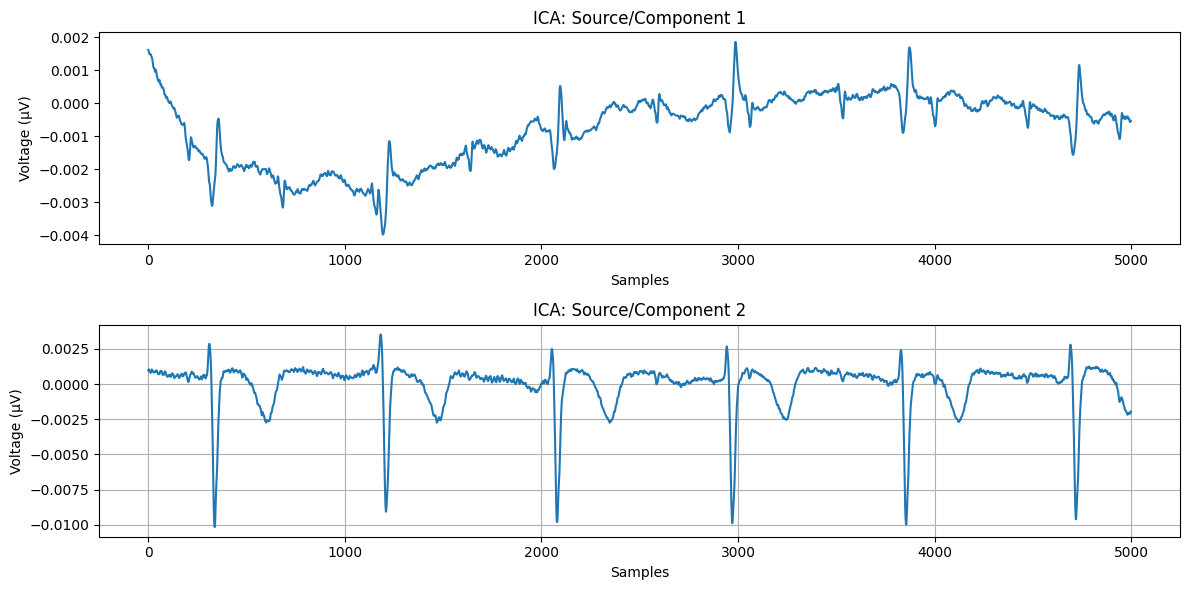

In [310]:
# Input start time and duration (in seconds) for signal plots.
# ----------------------
start_time = 0
duration = 5  # Each signal lasts 300sec.
# ----------------------

# print("Demixing Matrix W1:\n", W1)
# print()
# print("Demixing Matrix W1 shape: (num of channels, num of sources) =", W1.shape)
# print()

# ex. For duration = 3000 sec, 300 * fs = 300 * 1000 = 300000 samples.
cropped_signals = S[:, start_time * int(fs):(start_time + duration) * int(fs)]
source_num = cropped_signals.shape[0]
plt.figure(figsize=(12, 3 * source_num))
for i in range(source_num):
    plt.subplot(source_num, 1, i + 1)
    plt.plot(cropped_signals[i,:])
    plt.title(f'ICA: Source/Component {i+1}')
    plt.xlabel('Samples')
    plt.ylabel('Voltage (μV)')

plt.tight_layout()
plt.grid()
plt.show()

# cropped_signals = S1[:, start_time * int(fs):(start_time + duration) * int(fs)]
# source_num = cropped_signals.shape[0]
# plt.figure(figsize=(12, 3 * source_num))
# for i in range(source_num):
#     plt.subplot(source_num, 1, i + 1)
#     plt.plot(cropped_signals[i,:])
#     plt.title(f'ICA: Component {i+1}')
#     plt.xlabel('Samples')
#     plt.ylabel('Voltage (μV)')

# plt.tight_layout()
# plt.grid()
# plt.show()

## **Part 3**: Maternal vs. Fetal ECG Identification

In this part the distiction between the Maternal and Fetal ECG is executed. The classification is achieved through the extraction of heart beat frequency of each Source. The one with higher frequency is matched to the Fetus and the lower to the Mother. To identify the Heart Rates, three different methods are utilized and compared:

1.   Fast Fourier Transform (FFT)
2.   Autocorrelation
3.   Wavelets






### **Part 3.1**: Fast Fourier Transform (FFT)

fetal_rr: [ 4.251  7.169 13.63  10.187 16.26   3.769 13.749  5.292  3.094  5.836]
maternal_rr: [ 4.251  7.169 13.63  10.187 16.26   3.769 13.749  5.292  3.094  5.836]
Component 0: Maternal | HR: nan bpm | Dom Freq: 0.29000000000000004 Hz


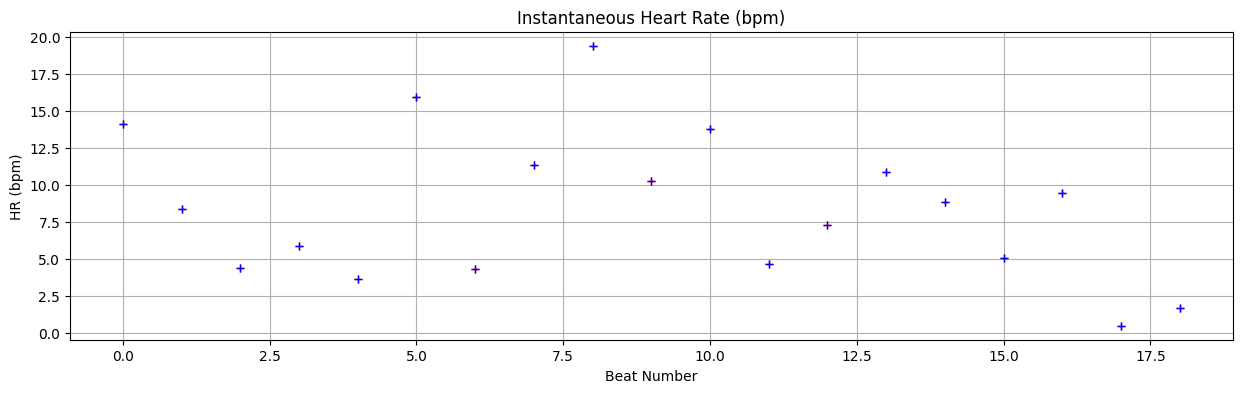

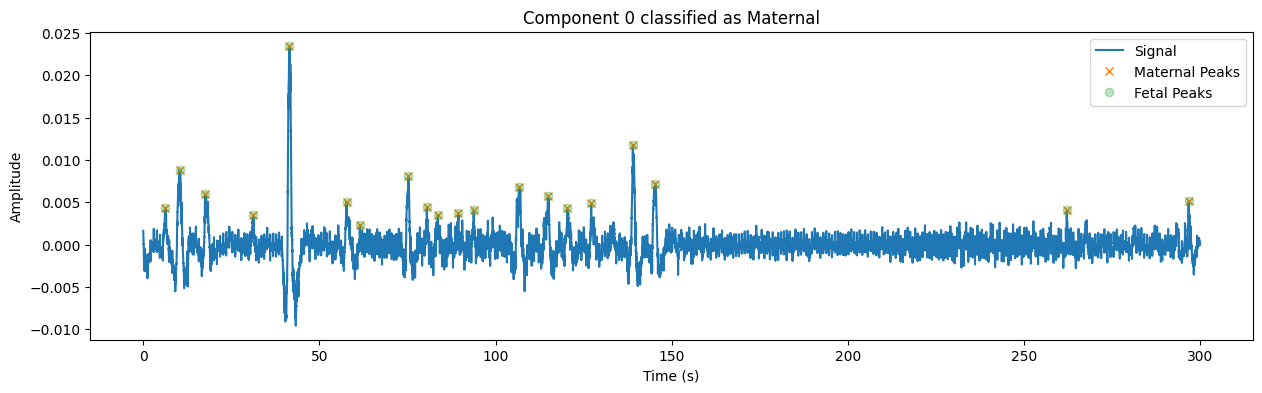

fetal_rr: [0.871 0.871 0.891 0.885 0.864 0.865 0.873 0.893 0.869 0.895]
maternal_rr: [0.871 0.871 0.891 0.885 0.864 0.865 0.873 0.893 0.869 0.895]
Component 1: Maternal | HR: 74.58 bpm | Dom Freq: 1.2566666666666668 Hz


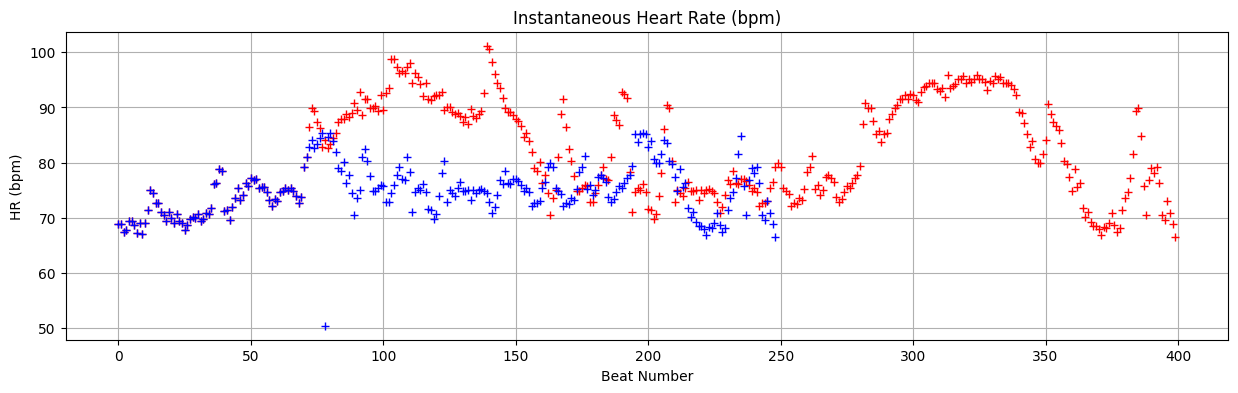

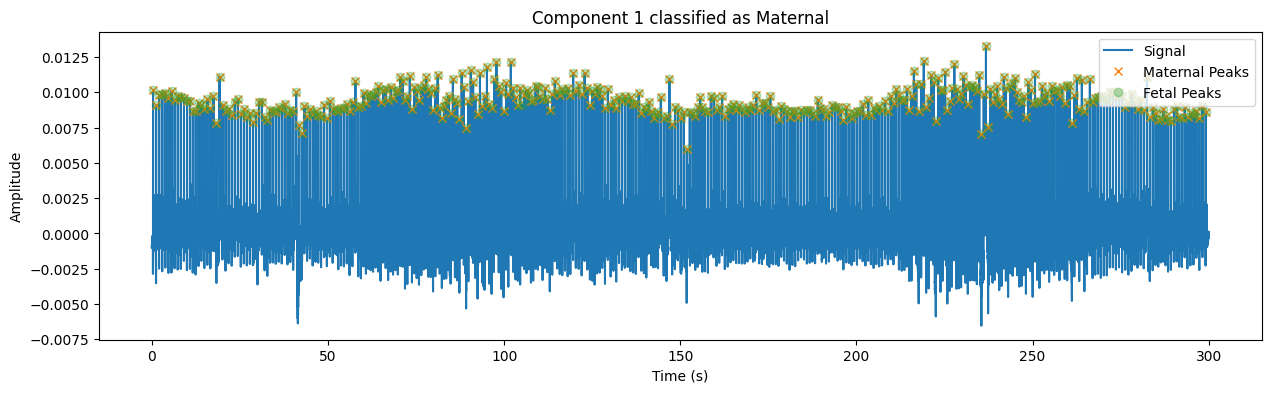

In [311]:
fetal_or_noise_signal = [1, ica_components.shape[0]]

for i in range(ica_components.shape[0]):
    duration_sec = int(300 * fs)
    rr_size = int(duration_sec / (fs * 10))
    signal = ica_components[i, :duration_sec]

    # Flip if average peak in -signal is stronger
    if np.max(-signal) > np.max(signal):
        signal = -signal

    # Maternal peaks
    maternal_peaks, maternal_props = find_peaks(signal, distance=int(0.6*fs), prominence=0.006)

    if len(maternal_peaks) > 1:
        maternal_rr = np.diff(maternal_peaks) / fs
        maternal_rr = maternal_rr[(maternal_rr > 0.7)]  # filter
        hr_maternal = 60 / np.mean(maternal_rr) if maternal_rr.size > rr_size else np.nan
    else:
        hr_maternal = np.nan

    # Fetal peaks
    fetal_peaks, fetal_props = find_peaks(signal, distance=int(min_rr*fs), prominence=0.006)
    ground_truth_rr = np.mean(rr_intervals) / fs
    if len(fetal_peaks) > 1:
        fetal_rr = np.diff(fetal_peaks) / fs # min_rr
        # fetal_rr = fetal_rr[(fetal_rr > ground_truth_rr-0.05) & (fetal_rr < ground_truth_rr+0.05)]  # filter
        hr_fetal = 60 / np.mean(fetal_rr) if maternal_rr.size > rr_size else np.nan
    else:
        hr_fetal = np.nan

    print(f"fetal_rr: {fetal_rr[:10]}")
    print(f"maternal_rr: {maternal_rr[:10]}")

    density_fetal = len(fetal_peaks) / duration_sec
    density_maternal = len(maternal_peaks) / duration_sec

    consistency_fetal = np.std(fetal_rr)
    consistency_maternal = np.std(maternal_rr)

    # Frequency domain analysis
    yf = np.abs(np.fft.rfft(signal))
    xf = np.fft.rfftfreq(signal.shape[0], 1 / fs)

    # Limit to cardiac-relevant band (0.5–5 Hz)
    mask = (xf > 0.1) & (xf < 5)
    dominant_freq = xf[mask][np.argmax(yf[mask])]

    fetal_ihr_hz = 1 / fetal_rr
    fetal_ihr_bpm = 60 / fetal_rr
    maternal_ihr_hz = 1 / maternal_rr
    maternal_ihr_bpm = 60 / maternal_rr

    if (np.abs(np.mean(fetal_ihr_bpm) - np.mean(maternal_ihr_bpm)) > 10) & (fetal_rr[0] > 20):
        label, hr = "Fetal or Noise", hr_fetal
        fetal_or_noise_signal.append(signal)
    else:
        label, hr = "Maternal", hr_maternal
    print(f"Component {i}: {label} | HR: {hr:.2f} bpm | Dom Freq: {dominant_freq} Hz")

    plt.figure(figsize=(15, 4))
    plt.plot(fetal_ihr_bpm, "r+", label="Fetal IHRs")
    plt.plot(maternal_ihr_bpm, "b+", label="Maternal IHRs")
    plt.title("Instantaneous Heart Rate (bpm)")
    plt.xlabel("Beat Number")
    plt.ylabel("HR (bpm)")
    plt.grid()
    plt.show()


    # Main plot:
    plt.figure(figsize=(15, 4))
    plt.plot(time[:duration_sec], signal, label="Signal")
    plt.plot(time[maternal_peaks], signal[maternal_peaks], "x", label="Maternal Peaks")
    plt.plot(time[fetal_peaks], signal[fetal_peaks], "o", label="Fetal Peaks", alpha=0.3)
    plt.title(f"Component {i} classified as {label}")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.show()

In [277]:
component_prominences = []

for i in range(ica_components.shape[0]):
    signal = ica_components[i, :]

    # Flip signal if needed to get upright QRS
    if np.max(-signal) > np.max(signal):
        signal = -signal

    # Use same distance for all components to compare fairly
    peaks, props = find_peaks(signal, distance=int(0.5 * fs), prominence=0.005)

    # Get average prominence
    if len(props["prominences"]) > 0:
        avg_prom = np.mean(props["prominences"])
    else:
        avg_prom = 0

    component_prominences.append({
        "index": i,
        "prominence": avg_prom,
        "signal": signal
    })



# Sort components by prominence
sorted_by_prom = sorted(component_prominences, key=lambda x: x["prominence"], reverse=True)

# Label top prominence as maternal, second as fetal
sorted_by_prom[0]["label"] = "Maternal"
sorted_by_prom[1]["label"] = "Fetal"

for component in sorted_by_prom:
    print(f"Component {component['index']}: {component['label']} | Prominence: {component['prominence']}")

Component 0: Maternal | Prominence: 0.010596190707407359
Component 1: Fetal | Prominence: 0.007398363400906872


In [252]:
pip install neurokit2


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 693.1/693.1 kB 10.9 MB/s eta 0:00:00


Component 0: Fetal | HR: 177.0 bpm | bSQI: 0.81


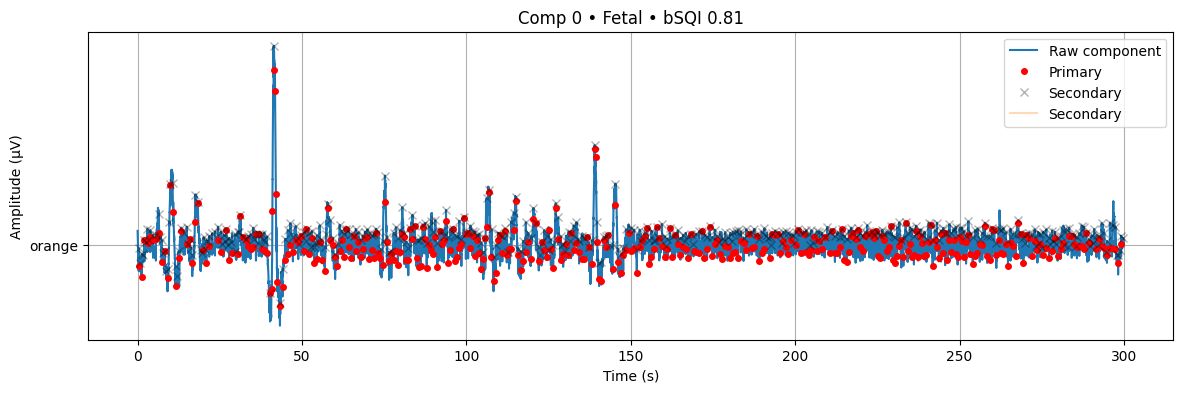

Component 1: Maternal | HR: 78.6 bpm | bSQI: 1.00


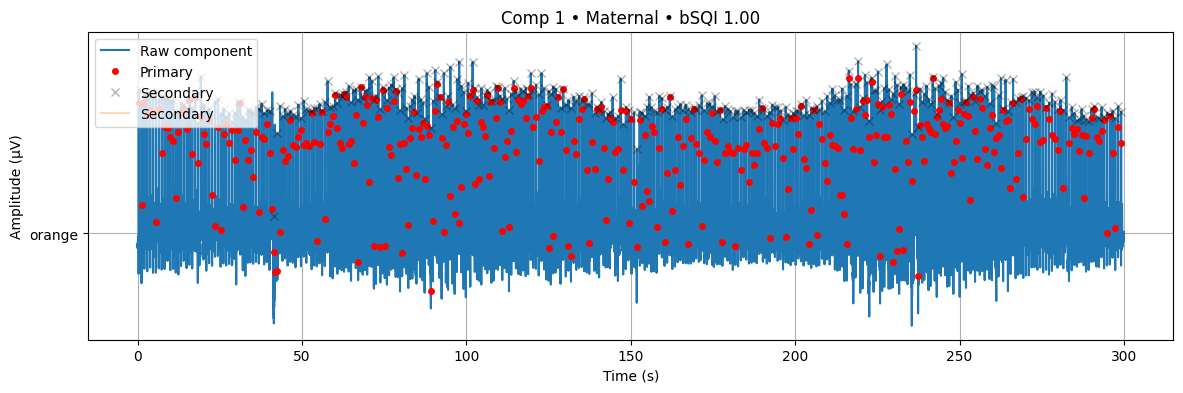

In [319]:
"""
QRS detection & component classification **χωρίς κανένα φιλτράρισμα**
===================================================================

•  Χρησιμοποιεί ωμή έξοδο ICA (raw microvolt signal).
•  Προσαρμοστικό κατώφλι πάνω σε energy‑envelope -> primary peaks.
•  Δεύτερος detector (NeuroKit2, αν υπάρχει· αλλιώς Pan‑Tompkins fallback)
   για bSQI ποιότητας.
•  Ταξινόμηση component σε Maternal / Fetal / Noise βάσει median HR &
   dominant spectral κορυφής.

Πριν τρέξεις, βεβαιώσου ότι υπάρχουν:
    ica_components  (n_components × n_samples)
    fs              (sampling frequency)
    time            (array χρόνων, s)

Optional: min_rr, rr_intervals για ground‑truth εμβρυϊκού RR.
"""

import numpy as np
import scipy.signal as sg
import matplotlib.pyplot as plt
import neurokit2 as nk

# -------------------------------------------------------------
# Helper functions (no filtering!)
# -------------------------------------------------------------

def energy_envelope(x, fs, win=0.1):
    """Energy of first derivative, smoothed over *win* seconds."""
    diff = np.diff(x, prepend=x[0])
    return np.convolve(diff**2, np.ones(int(win*fs)), mode="same")


def detect_peaks_primary(x, fs):
    env = energy_envelope(x, fs)
    thr = 0.6 * np.percentile(env, 98)
    pks, _ = sg.find_peaks(env, height=thr, distance=int(0.25*fs))
    return pks, env


# ---- fallback Pan‑Tompkins (extremely απλοποιημένος) ---------------

def pt_simple(x, fs):
    diff = np.diff(x, prepend=x[0])
    pks, _ = sg.find_peaks(diff, distance=int(0.25*fs))
    return pks


def detect_peaks_secondary(x, fs):
    if HAS_NK:
        _, info = nk.ecg_peaks(x, sampling_rate=fs, correct_artifacts=False)
        return info["ECG_R_Peaks"]
    return pt_simple(x, fs)


def bsqi(p1, p2, tol):
    """Beat‑based Signal Quality Index μεταξύ δύο λιστών peaks."""
    if len(p1) == 0 or len(p2) == 0:
        return 0.0
    i = j = matches = 0
    while i < len(p1) and j < len(p2):
        if abs(p1[i] - p2[j]) <= tol:
            matches += 1
            i += 1
            j += 1
        elif p1[i] < p2[j]:
            i += 1
        else:
            j += 1
    return matches / max(len(p1), len(p2))

# -------------------------------------------------------------
# MAIN LOOP  (no filtering, raw signals)
# -------------------------------------------------------------
for i in range(ica_components.shape[0]):
    dur_samples = int(300 * fs)
    sig = ica_components[i, :dur_samples].astype(float)

    # Flip so that QRS είναι θετικά
    if np.max(-sig) > np.max(sig):
        sig = -sig

    primary, env = detect_peaks_primary(sig, fs)
    secondary   = detect_peaks_secondary(sig, fs)
    sqi_val     = bsqi(primary, secondary, tol=int(0.05*fs))

    rr_all = np.diff(primary) / fs
    rr_m   = rr_all[(rr_all > 0.4) & (rr_all < 1.5)]   # 40‑150 bpm
    rr_f   = rr_all[(rr_all > 0.25) & (rr_all < 0.55)] # 110‑240 bpm

    hr_m = 60/np.median(rr_m) if rr_m.size >= 4 else np.nan
    hr_f = 60/np.median(rr_f) if rr_f.size >= 4 else np.nan

    xf = np.fft.rfftfreq(sig.size, 1/fs)
    yf = np.abs(np.fft.rfft(sig))
    dom_band = (xf > 0.1) & (xf < 5)
    dom_hr   = 60 * xf[dom_band][np.argmax(yf[dom_band])]

    if 110 <= hr_f <= 200:
        label, hr_sel = "Fetal", hr_f
    elif 40 <= hr_m < 110:
        label, hr_sel = "Maternal", hr_m
    elif 110 <= dom_hr <= 200:
        label, hr_sel = "Fetal", dom_hr
    else:
        label, hr_sel = "Noise", np.nan

    print(f"Component {i}: {label} | HR: {hr_sel:.1f} bpm | bSQI: {sqi_val:.2f}")

    # ---- Plots ------------------------------------------------------
    t = time[:dur_samples]
    plt.figure(figsize=(14,4))
    plt.plot(t, sig, label="Raw component")
    plt.plot(t[primary],   sig[primary],   "ro", ms=4, label="Primary")
    plt.plot(t[secondary], sig[secondary], "kx", 'orange', alpha=0.3, label="Secondary")
    plt.title(f"Comp {i} • {label} • bSQI {sqi_val:.2f}")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude (µV)")
    plt.legend(); plt.grid(True); plt.show()


Comp 0: Fetal | HR: 160.9 bpm | prom=0.003 | bSQI=0.97 | domHR=31.2


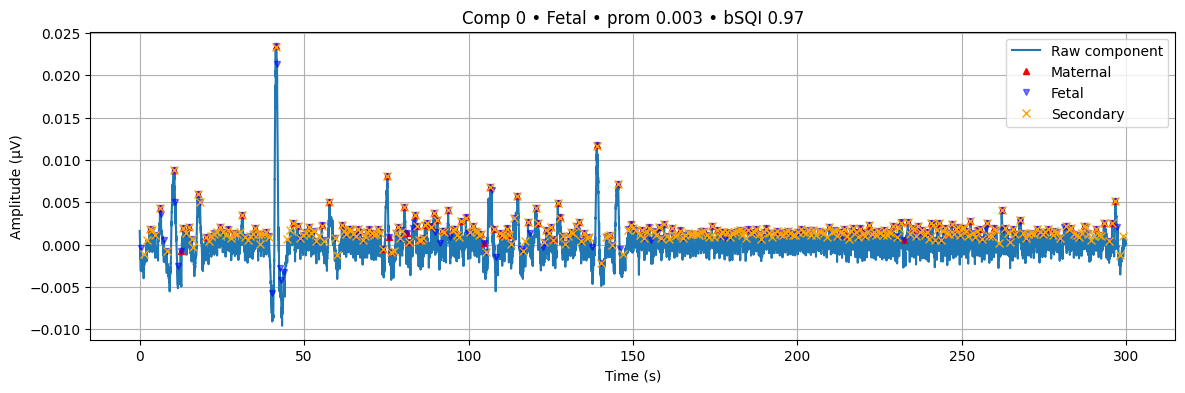

Comp 1: Fetal | HR: 216.6 bpm | prom=0.003 | bSQI=1.00 | domHR=75.4


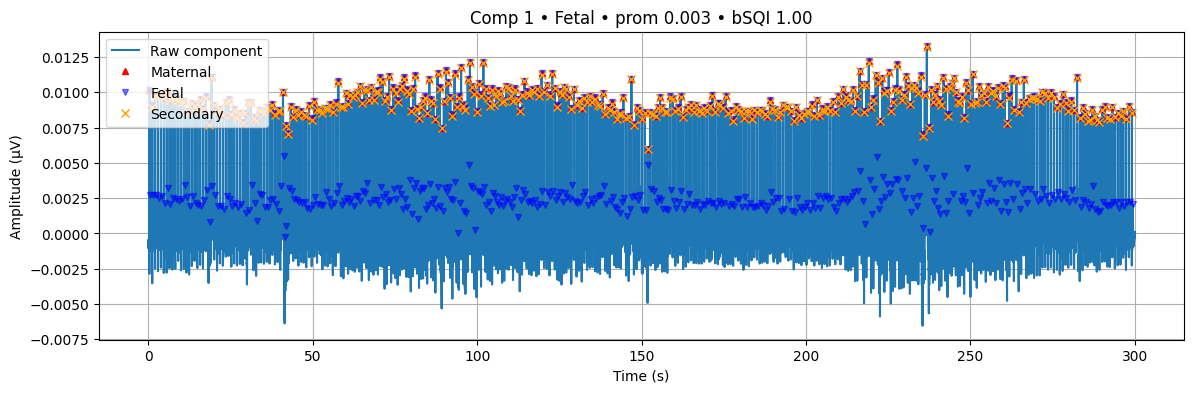

In [320]:
"""
QRS detection & ICA component classification – raw‑signal + **adaptive prominence**
===============================================================================
•  Δεν εφαρμόζουμε κανένα προ‑φιλτράρισμα· το ICA component αναλύεται ωμό.
•  **Προσαρμοζόμενο prominence**
   └─ Εκτίμηση HR μέσω κυρίαρχης συχνότητας (FFT, 0.5–5 Hz).
      * Αν HR_est > 180 bpm → `prominence = 0.006`
      * Αλλιώς               → `prominence = 0.003`
•  bSQI = συμφωνία πρωτεύοντος detector με δευτερεύον (NeuroKit2 Nabian2018 ή
   εσωτερικό Pan‑Tompkins fallback).
•  Προαιρετική οπτικοποίηση (`show_plots=True`).
"""

from __future__ import annotations

import numpy as np
import scipy.signal as sg
import warnings
from typing import Tuple, Dict, List, Any
import matplotlib.pyplot as plt

# ---------------------------------------------------------------------
# Optional secondary detector (NeuroKit2). Fallback = minimal Pan‑Tompkins
# ---------------------------------------------------------------------
try:
    import neurokit2 as nk
    HAVE_NK = True
except ModuleNotFoundError:
    HAVE_NK = False
    warnings.warn("NeuroKit2 not found – falling back to internal Pan‑Tompkins.")

def _pantompkins(sig: np.ndarray, fs: float) -> np.ndarray:
    """Light Pan‑Tompkins implementation (no pre‑filtering)."""
    diff = np.diff(sig, prepend=sig[0])
    energy = sg.convolve(diff ** 2,
                         np.ones(int(0.08 * fs)) / (0.08 * fs),
                         mode="same")
    th = 0.6 * np.percentile(energy, 98)
    peaks, _ = sg.find_peaks(energy, height=th, distance=int(0.25 * fs))
    return peaks

# ---------------------------------------------------------------------
# bSQI – returns (value, secondary_peaks)
# ---------------------------------------------------------------------

def bsqi(primary: np.ndarray, sig: np.ndarray, fs: float) -> Tuple[float, np.ndarray]:
    if primary.size < 2:
        return 0.0, np.array([])

    if HAVE_NK:
        sec_peaks = nk.ecg_peaks(sig, sampling_rate=fs, method="nabian2018")[1][
            "ECG_R_Peaks"
        ]
    else:
        sec_peaks = _pantompkins(sig, fs)

    if len(sec_peaks) == 0:
        return 0.0, sec_peaks

    tol = int(0.05 * fs)  # ±50 ms
    agree = sum(np.any(np.abs(sec_peaks - p) <= tol) for p in primary)
    return agree / primary.size, sec_peaks

# ---------------------------------------------------------------------
# Raw‑signal peak detector with adaptive prominence
# ---------------------------------------------------------------------

def detect_raw_peaks(sig: np.ndarray,
                     fs: float,
                     min_dist: float,
                     prominence: float) -> np.ndarray:
    """Wrapper γύρω από scipy.signal.find_peaks."""
    return sg.find_peaks(sig,
                        distance=int(min_dist * fs),
                        prominence=prominence)[0]

# ---------------------------------------------------------------------
# Main processing loop
# ---------------------------------------------------------------------

def process_components(
    ica_components: np.ndarray,
    fs: float,
    time: np.ndarray,
    *,
    prom_high: float = 0.006,
    prom_low: float = 0.003,
    prom_fet: float = 0.002,
    hr_switch: float = 180.0,
    show_plots: bool = True,
) -> List[Dict[str, Any]]:
    """Analyse components and optionally draw diagnostic plots.

    prominence for maternal detector is chosen per‑component:
      – Estimate HR from dominant spectral peak.
      – If HR_est > hr_switch ⇒ prominence = prom_high else prom_low.
    """

    results: List[Dict[str, Any]] = []
    dur_samples = int(300 * fs)  # analyse first 5 min

    for i in range(ica_components.shape[0]):
        sig = ica_components[i, :dur_samples].astype(float)

        # Flip polarity so biggest peak is positive
        if np.max(-sig) > np.max(sig):
            sig = -sig

        # ----------- Quick HR estimate via FFT (0.5–5 Hz) ------------
        yf = np.abs(np.fft.rfft(sig))
        xf = np.fft.rfftfreq(sig.size, 1 / fs)
        band = (xf > 0.1) & (xf < 5)
        dom_hr_est = 60 * xf[band][np.argmax(yf[band])]

        prom_mat = prom_high if dom_hr_est > hr_switch else prom_low

        # -------------- Peak detection ------------------------------
        mat_peaks = detect_raw_peaks(sig, fs, 0.6, prom_mat)
        fet_peaks = detect_raw_peaks(sig, fs, 0.25, prom_fet)

        # RR intervals & HR
        mat_rr = np.diff(mat_peaks) / fs if mat_peaks.size > 1 else np.array([])
        mat_rr = mat_rr[(mat_rr > 0.4) & (mat_rr < 1.5)]
        hr_mat = 60 / np.median(mat_rr) if mat_rr.size else np.nan

        fet_rr = np.diff(fet_peaks) / fs if fet_peaks.size > 1 else np.array([])
        fet_rr = fet_rr[(fet_rr > 0.25) & (fet_rr < 0.55)]
        hr_fet = 60 / np.median(fet_rr) if fet_rr.size else np.nan

        # bSQI
        sqi_val, sec_peaks = bsqi(mat_peaks, sig, fs)

        # Decision logic
        if not np.isnan(hr_fet) and hr_fet >= 110:
            label, hr = "Fetal", hr_fet
        elif not np.isnan(hr_mat) and hr_mat <= 110:
            label, hr = "Maternal", hr_mat
        elif 110 <= dom_hr_est <= 200:
            label, hr = "Fetal", dom_hr_est
        else:
            label, hr = "Noise", np.nan

        results.append(
            {
                "component": i,
                "label": label,
                "hr": hr,
                "maternal_peaks": mat_peaks,
                "fetal_peaks": fet_peaks,
                "secondary_peaks": sec_peaks,
                "bSQI": sqi_val,
                "dom_hr_est": dom_hr_est,
                "prom_used": prom_mat,
            }
        )

        # -------------- Diagnostic plots ---------------------------
        print(
            f"Comp {i}: {label} | HR: {hr:.1f} bpm | prom={prom_mat:.3f} | bSQI={sqi_val:.2f} | domHR={dom_hr_est:.1f}"
        )

        if show_plots:
            t = time[:dur_samples]
            plt.figure(figsize=(14, 4))
            plt.plot(t, sig, label="Raw component")
            plt.plot(t[mat_peaks], sig[mat_peaks], "r^", ms=5, label="Maternal")
            if fet_peaks.size:
                plt.plot(t[fet_peaks], sig[fet_peaks], "bv", ms=4, alpha=0.5, label="Fetal")
            if len(sec_peaks):
                plt.plot(t[sec_peaks], sig[sec_peaks], "x", color="orange", ms=6, label="Secondary")
            plt.title(f"Comp {i} • {label} • prom {prom_mat:.3f} • bSQI {sqi_val:.2f}")
            plt.xlabel("Time (s)")
            plt.ylabel("Amplitude (µV)")
            plt.legend(); plt.grid(True); plt.show()

    return results

# ---------------------------------------------------------------------
# Example usage (comment/remove when integrating):
# ---------------------------------------------------------------------
results = process_components(ica_components, fs, time)


### **Part 3.2**: Autocorrelation

### **Part 3.3**: Wavelets

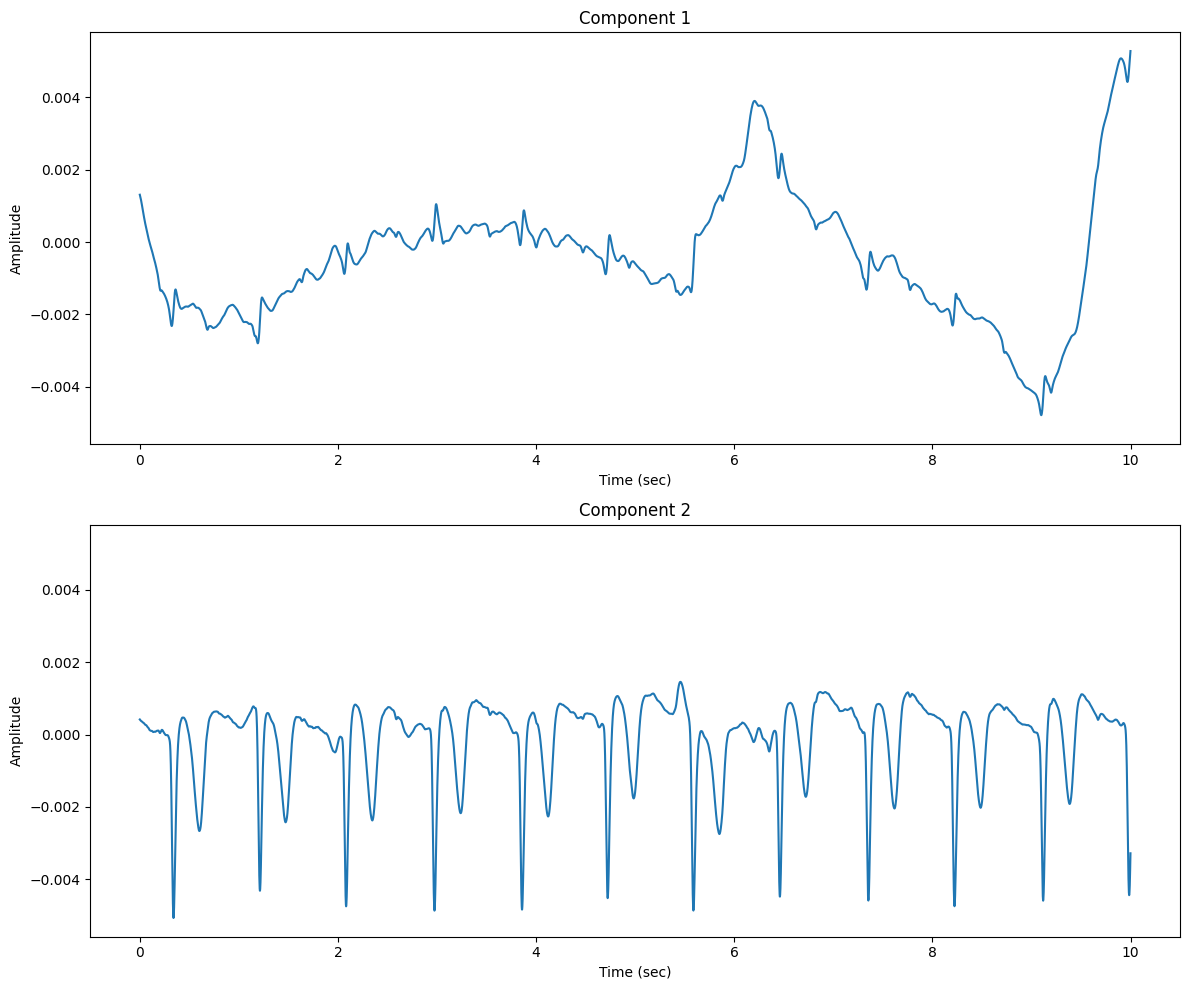

In [266]:
def bandpass_filter(data, lowcut, highcut, fs, order=1):
    nyq = 0.5 * fs  # συχνότητα Nyquists
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data)

filtered_signals = np.zeros_like(ica_components)

for i in range(ica_components.shape[0]):
    filtered_signals[i, :] = bandpass_filter(
        data=ica_components[i, :],
        lowcut= 0.1,
        highcut=10,
        fs=fs,
    )

fig, axes = plt.subplots(filtered_signals.shape[0], 1, sharey=True, figsize=(12, 10))
for i, ax in enumerate(axes):
    ax.plot(time[:10000], filtered_signals[i, :10000])
    ax.set_title(f'Component {i+1}')
    ax.set_xlabel('Time (sec)')
    ax.set_ylabel('Amplitude')
plt.tight_layout()
plt.show()

ica_components.shape: (2, 300000)
ica_components[0].shape (first row): (300000,)


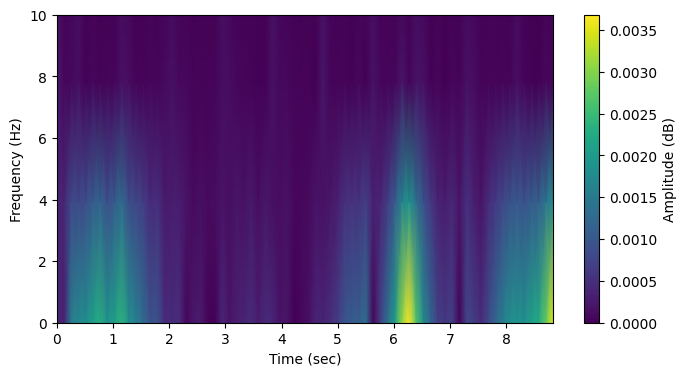

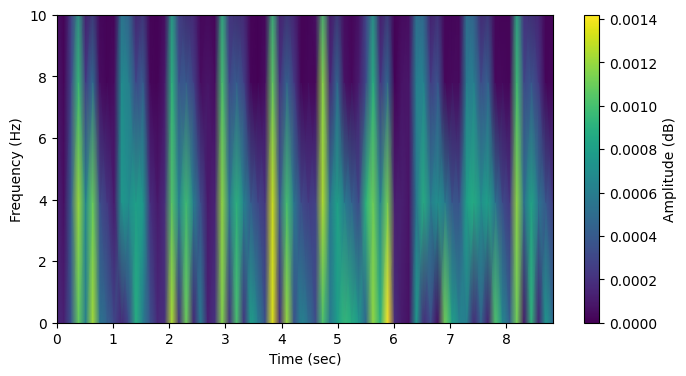

In [267]:
print("ica_components.shape:", ica_components.shape)
print("ica_components[0].shape (first row):", ica_components[1].shape)

time_limit = 70
for i in range(filtered_signals.shape[0]):
  # Compute the STFT on the selected component
  f, t, Zxx = stft(filtered_signals[i, :], fs=fs, nperseg=256)

  # print("Shape of f:", f.shape)
  # print("Shape of t:", t.shape)
  # print("Shape of Zxx:", Zxx.shape)

  # Plot the spectrogram
  plt.figure(figsize=(8, 4))
  plt.pcolormesh(t[:time_limit], f, np.abs(Zxx[:, :time_limit]), shading='gouraud')
  plt.ylabel("Frequency (Hz)")
  plt.xlabel("Time (sec)")
  plt.colorbar(label="Amplitude (dB)")
  plt.ylim([0, 10])
  plt.show()

In [ ]:
!pip install PyWavelets
import pywt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 43.4 MB/s eta 0:00:00


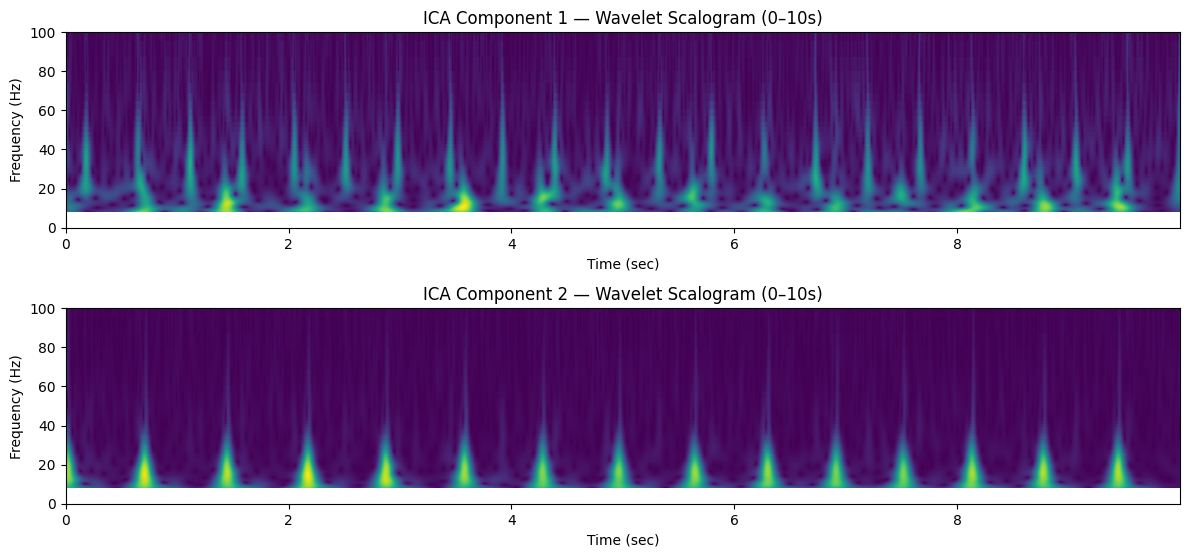

In [ ]:
end_idx = int(10 * fs)
time_limit = time[:end_idx]
time = np.arange(ica_components.shape[1]) / fs

wavelet = 'cmor1.5-1.0'         # complex Morlet
scales = np.arange(1, 128)      # max scale for resolution

plt.figure(figsize=(12, 8))
for i in range(ica_components.shape[0]):
    sig10 = ica_components[i, :end_idx]
    coeffs, freqs = pywt.cwt(sig10, scales, wavelet, sampling_period=1/fs)

    plt.subplot(3, 1, i+1)
    plt.pcolormesh(time_limit, freqs, np.abs(coeffs), shading='auto')
    plt.title(f'ICA Component {i+1} — Wavelet Scalogram (0–10s)')
    plt.ylabel('Frequency (Hz)')
    plt.xlabel('Time (sec)')
    plt.ylim(0, 100)

plt.tight_layout()
plt.show()

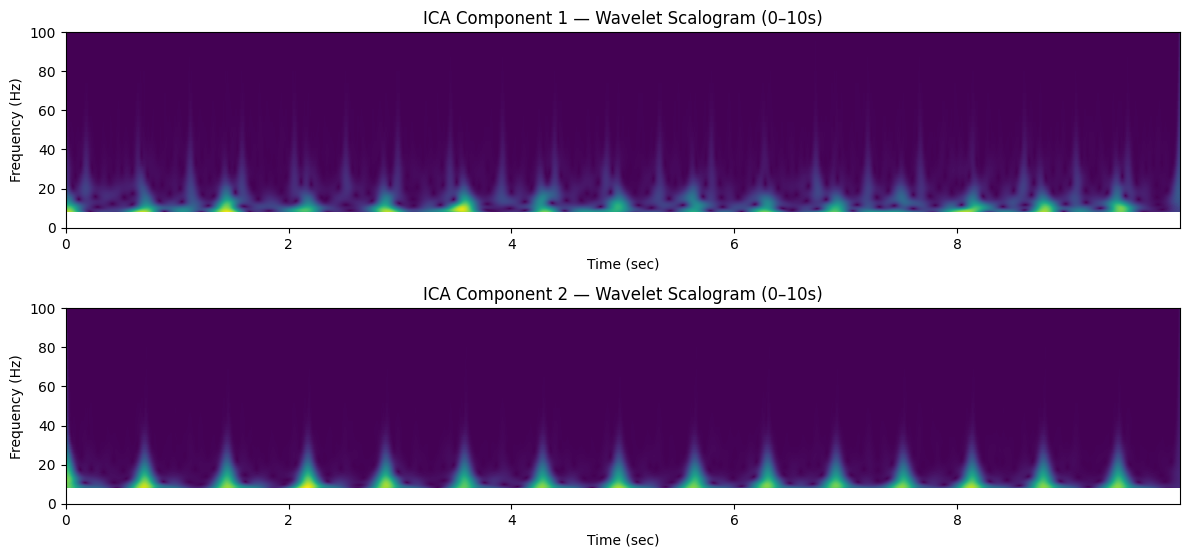

In [ ]:
plt.figure(figsize=(12, 8))
for i in range(filtered_signals.shape[0]):
    sig10 = filtered_signals[i, :end_idx]
    coeffs, freqs = pywt.cwt(sig10, scales, wavelet, sampling_period=1/fs)

    plt.subplot(3, 1, i+1)
    plt.pcolormesh(time_limit, freqs, np.abs(coeffs), shading='auto')
    plt.title(f'ICA Component {i+1} — Wavelet Scalogram (0–10s)')
    plt.ylabel('Frequency (Hz)')
    plt.xlabel('Time (sec)')
    plt.ylim(0, 100)

plt.tight_layout()
plt.show()